In [32]:
import os
import shutil
import random
import numpy as np
from io import BytesIO
from PIL import Image
import requests
import urllib
from IPython.display import display

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow import keras
import tensorflow.lite as tflite

import matplotlib.pyplot as plt

%matplotlib inline

dataset is taken from https://www.kaggle.com/alxmamaev/flowers-recognition

In [11]:
path = '../data/flowers/'

In [5]:
target_size = (150, 150)

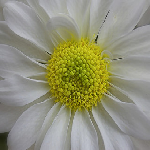

In [6]:
img = load_img(f'{path}daisy/100080576_f52e8ee070_n.jpg', target_size=target_size)
img

# Split data in test, train, validation

In [18]:
flower_types = ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']

In [18]:
for flower_type in flower_types:
    images = os.listdir(os.path.join(path, flower_type))
    print(f'flower: {flower_type:>10} - number images: {len(images)}')

flower:      daisy - number images: 764
flower:       rose - number images: 784
flower:      tulip - number images: 984
flower:  dandelion - number images: 1052
flower:  sunflower - number images: 733


In [20]:
for folder in ['train', 'validation', 'test']:
    for flower_type in flower_types:
        directory = os.path.join(path, folder, flower_type)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f'created dir {directory}')

created dir ../data/flowers/train/daisy
created dir ../data/flowers/train/rose
created dir ../data/flowers/train/tulip
created dir ../data/flowers/train/dandelion
created dir ../data/flowers/train/sunflower
created dir ../data/flowers/validation/daisy
created dir ../data/flowers/validation/rose
created dir ../data/flowers/validation/tulip
created dir ../data/flowers/validation/dandelion
created dir ../data/flowers/validation/sunflower
created dir ../data/flowers/test/daisy
created dir ../data/flowers/test/rose
created dir ../data/flowers/test/tulip
created dir ../data/flowers/test/dandelion
created dir ../data/flowers/test/sunflower


In [32]:
test_size = 0.15
val_size = 0.15

for flower_type in flower_types:
    flower_type_path = os.path.join(path, flower_type)
    images = os.listdir(flower_type_path)
    
    total_num_images = len(images)
    random.seed(1)
    random.shuffle(images)
    
    num_test_images = int(total_num_images*test_size)
    num_val_images = int(total_num_images*val_size)
    num_train_images = total_num_images - num_test_images - num_val_images
    
    for i in range(num_test_images):
        img = images.pop()
        image_path = os.path.join(flower_type_path, img)
        shutil.copyfile(image_path, f'{path}/test/{flower_type}/{img}')
        
    for i in range(num_val_images):
        img = images.pop()
        image_path = os.path.join(flower_type_path, img)
        shutil.copyfile(image_path, f'{path}/validation/{flower_type}/{img}')
        
    for i in range(len(images)):
        img = images.pop()
        image_path = os.path.join(flower_type_path, img)
        shutil.copyfile(image_path, f'{path}/train/{flower_type}/{img}')

# EDA

## check imbalance

In [20]:
flower_dict = {}
for flower_type in flower_types:
    flower_dict[flower_type] = {}
    for folder in ['test', 'train', 'validation']:
        flower_path = os.path.join(path, folder, flower_type)
        if os.path.isdir(flower_path):
            images = os.listdir(flower_path)
            flower_dict[flower_type][folder] = len(images)
            print(f'flower: {flower_type:>10} - {folder} - number images: {len(images)}')

flower:      daisy - test - number images: 114
flower:      daisy - train - number images: 536
flower:      daisy - validation - number images: 114
flower:       rose - test - number images: 117
flower:       rose - train - number images: 550
flower:       rose - validation - number images: 117
flower:      tulip - test - number images: 147
flower:      tulip - train - number images: 690
flower:      tulip - validation - number images: 147
flower:  dandelion - test - number images: 157
flower:  dandelion - train - number images: 738
flower:  dandelion - validation - number images: 157
flower:  sunflower - test - number images: 109
flower:  sunflower - train - number images: 515
flower:  sunflower - validation - number images: 109


Text(0.5, 1.0, 'training data')

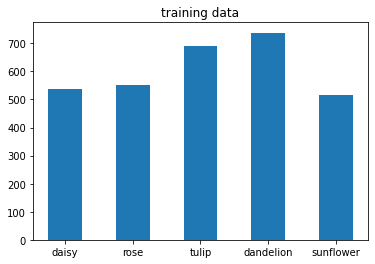

In [25]:
plt.bar(flower_types, [flower_dict[flower]['train'] for flower in flower_types], width=.5)
plt.title('training data')

the data set seems to be balanced

## investigate image sizes

In [26]:
def get_dims(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    arr = np.array(img, dtype='float32')
    h, w, d = arr.shape
    return h, w

In [29]:
size_dict = {}
for flower_type in flower_types:
    size_dict[flower_type] = []
    for folder in ['test', 'train', 'validation']:
        flower_path = os.path.join(path, folder, flower_type)
        if os.path.isdir(flower_path):
            images = os.listdir(flower_path)
            for image in images:
                h, w = get_dims(f'{flower_path}/{image}')
                size_dict[flower_type].append({'hight': h, 'width': w})

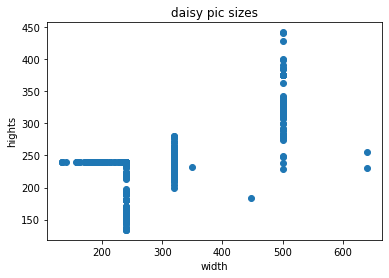

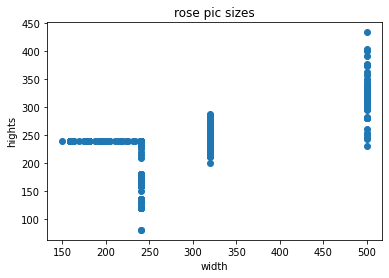

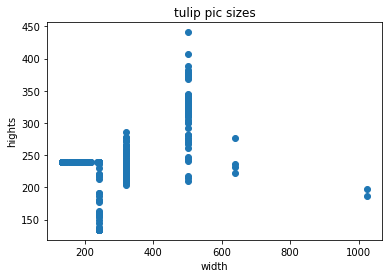

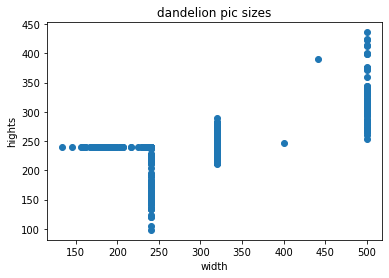

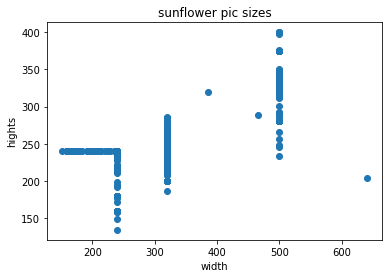

In [31]:
for flower in flower_types:
    hights = [pic['hight'] for pic in size_dict[flower]]
    widths = [pic['width'] for pic in size_dict[flower]]
    plt.scatter(widths, hights)
    plt.xlabel('width')
    plt.ylabel('hights')
    plt.title(f'{flower} pic sizes (pixels)')
    plt.pause(0.1)

size distribution between the different flower types seems similar

## show random images

../data/flowers/test/daisy


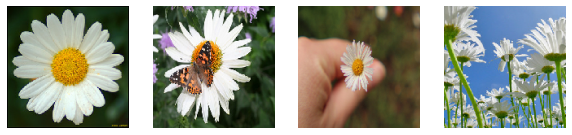

../data/flowers/train/daisy


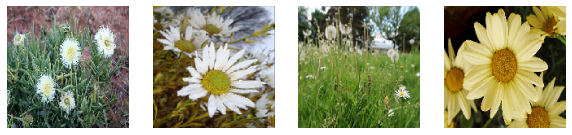

../data/flowers/validation/daisy


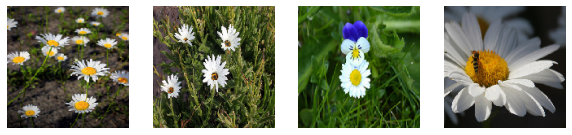

../data/flowers/test/rose


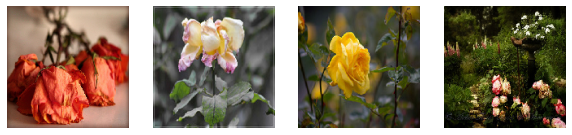

../data/flowers/train/rose


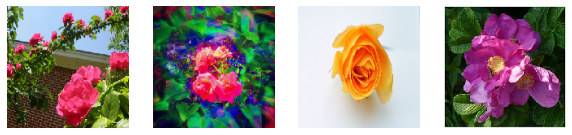

../data/flowers/validation/rose


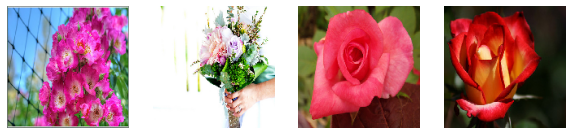

../data/flowers/test/tulip


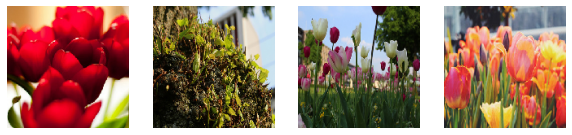

../data/flowers/train/tulip


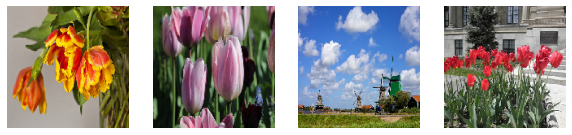

../data/flowers/validation/tulip


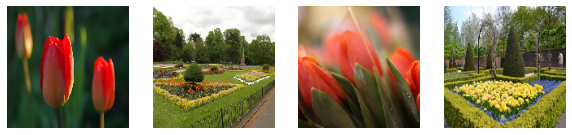

../data/flowers/test/dandelion


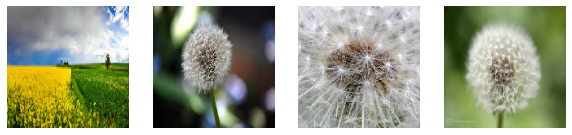

../data/flowers/train/dandelion


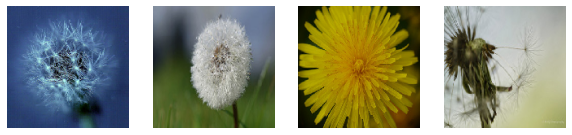

../data/flowers/validation/dandelion


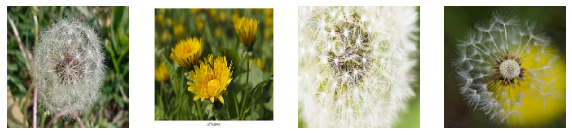

../data/flowers/test/sunflower


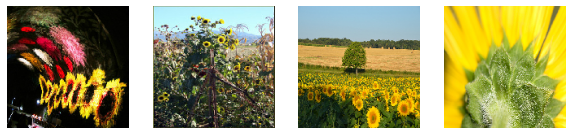

../data/flowers/train/sunflower


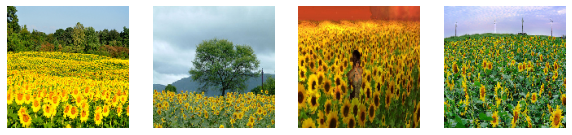

../data/flowers/validation/sunflower


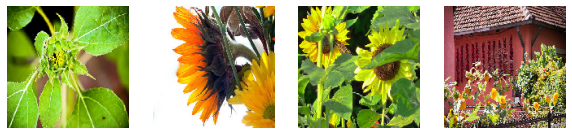

In [49]:
for flower_type in flower_types:
    for folder in ['test', 'train', 'validation']:
        flower_path = os.path.join(path, folder, flower_type)
        if os.path.isdir(flower_path):
            print(flower_path)
            images = os.listdir(flower_path)
            random.seed(1)
            random.shuffle(images)
            f, axarr = plt.subplots(1, 4, figsize=(10, 20))
            for i, img in enumerate(images[:4]):
                axarr[i].imshow(load_img(f'{flower_path}/{img}', target_size=target_size))
                axarr[i].axis('off')
            plt.pause(0.1)

almost all images look good

# linear model

# start with easy model

In [16]:
def make_model():
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3))
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    flatten = keras.layers.Flatten()(pooling)
    dense = keras.layers.Dense(64, activation='relu')(flatten)
    outputs = keras.layers.Dense(len(flower_types), activation='softmax')(dense)
    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.SGD(lr=0.002, momentum=0.8)
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

In [17]:
model = make_model()

/Users/a844494/.pyenv/versions/zoomcamp/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                11214912  
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                           

In [19]:
train_generator = ImageDataGenerator(rescale=1./255)

train_data = train_generator.flow_from_directory(
    f'{path}train/',
    target_size=target_size,
    batch_size=20
)

Found 3029 images belonging to 5 classes.


In [20]:
val_generator = ImageDataGenerator(rescale=1./255)

val_data = val_generator.flow_from_directory(
    f'{path}validation',
    target_size=target_size,
    batch_size=20,
    shuffle=True
)

Found 644 images belonging to 5 classes.


In [21]:
train_data.class_mode

'categorical'

In [69]:
flower_types_pred_dict = {v:k for k, v in train_data.class_indices.items()}

In [22]:
history = model.fit(
    train_data,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_data,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 24s 231ms/step - loss: 1.4376 - accuracy: 0.3655 - val_loss: 1.2968 - val_accuracy: 0.3991
Epoch 2/10
100/100 [==============================] - 16s 160ms/step - loss: 1.2128 - accuracy: 0.4751
Epoch 3/10
100/100 [==============================] - 16s 159ms/step - loss: 1.1401 - accuracy: 0.5304
Epoch 4/10
100/100 [==============================] - 14s 138ms/step - loss: 1.0906 - accuracy: 0.5586
Epoch 5/10
100/100 [==============================] - 15s 146ms/step - loss: 1.0127 - accuracy: 0.6025
Epoch 6/10
100/100 [==============================] - 15s 152ms/step - loss: 0.9669 - accuracy: 0.6145
Epoch 7/10
100/100 [==============================] - 15s 147ms/step - loss: 0.9269 - accuracy: 0.6556
Epoch 8/10
100/100 [==============================] - 15s 146ms/step - loss: 0.8542 - accuracy: 0.6843
Epoch 9/10
100/100 [==============================] - 15s 149ms/step - loss: 0.8365 - accuracy: 0.6805
Epoch 10/10
100/100 [==========

# save model

In [27]:
model_path = '../models/flowers-model-v1.tflite'

In [26]:
converter = tflite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open(model_path, 'wb') as f_out:
    f_out.write(tflite_model)

2021-12-11 13:40:48.727984: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmpffdxbb3v/assets


2021-12-11 13:40:50.245621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-11 13:40:50.245644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-11 13:40:50.249551: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmpffdxbb3v
2021-12-11 13:40:50.253313: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-12-11 13:40:50.253337: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmpffdxbb3v
2021-12-11 13:40:50.262575: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-12-11 13:40:50.398964: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /var/folders/rk/h56j88l56js33mhr0p2z2y5h0000gn/T/tmpffdxbb3v
2021-12

In [28]:
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [54]:
def prepare_image(img_path, target_size):
    with open(img_path, 'rb') as file:
        img = file.read()
        stream = BytesIO(img)
        img = Image.open(stream)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    
    x = np.array(img, dtype='float32')
    X = np.array([x])
    X /= 255.0
    
    return X

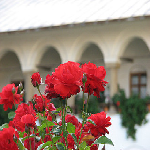

In [55]:
test_image = f'{path}test/rose/1461381091_aaaa663bbe_n.jpg'
load_img(test_image, target_size=target_size)

In [56]:
X = prepare_image(test_image, target_size)

In [58]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [71]:
flower_types_pred_dict

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [70]:
flower_types_pred_dict[preds.argmax()]

'rose'

# test local API

In [2]:
def download_image(url):
    with urllib.request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def resize_image(image, target_size):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = image.resize(target_size, Image.NEAREST)
    return image

In [3]:
image_urls = [
    'https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/a/a8/Tulipa_cinnabarina_subsp_cinnabarina.png',
    'https://upload.wikimedia.org/wikipedia/commons/8/85/Tulipa_praestans1.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/ea/Tulipa_suaveolens_floriade_to_Canberra.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/eb/Wild_Rosa_gallica_Romania.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/0/0c/Rosa_Ave_Maria_1.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/f/f7/2010_sonnenblume_%28Helianthus_annuus%29.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/e/e9/Sonsbeck_-_agri_06_ies.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/d/d6/Taraxacum_officinale_focused.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/8/85/01_pusteblume.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/5/5a/Bellis_perennis-fully_bloomed_flower.jpg'    
]

https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg


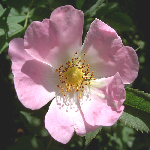

https://upload.wikimedia.org/wikipedia/commons/a/a8/Tulipa_cinnabarina_subsp_cinnabarina.png


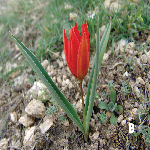

https://upload.wikimedia.org/wikipedia/commons/8/85/Tulipa_praestans1.jpg


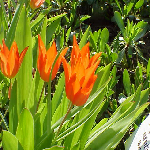

https://upload.wikimedia.org/wikipedia/commons/e/ea/Tulipa_suaveolens_floriade_to_Canberra.jpg


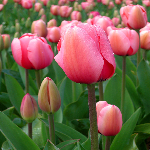

https://upload.wikimedia.org/wikipedia/commons/e/eb/Wild_Rosa_gallica_Romania.jpg


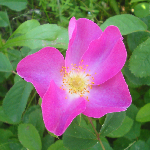

https://upload.wikimedia.org/wikipedia/commons/0/0c/Rosa_Ave_Maria_1.jpg


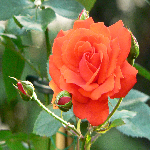

https://upload.wikimedia.org/wikipedia/commons/f/f7/2010_sonnenblume_%28Helianthus_annuus%29.JPG


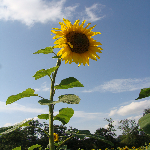

https://upload.wikimedia.org/wikipedia/commons/e/e9/Sonsbeck_-_agri_06_ies.jpg


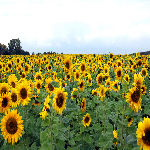

https://upload.wikimedia.org/wikipedia/commons/d/d6/Taraxacum_officinale_focused.jpg


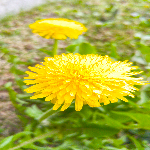

https://upload.wikimedia.org/wikipedia/commons/8/85/01_pusteblume.jpg


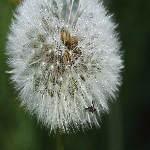

https://upload.wikimedia.org/wikipedia/commons/5/5a/Bellis_perennis-fully_bloomed_flower.jpg


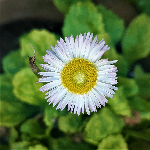

In [8]:
for url in image_urls:
    print(url)
    img = download_image(url)
    img = resize_image(img, target_size)
    display(img)

https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg


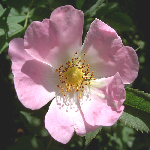

ConnectionError: HTTPConnectionPool(host='192.168.178.36', port=9696): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x154e95fa0>: Failed to establish a new connection: [Errno 60] Operation timed out'))

In [19]:
url = 'http://192.168.178.36:9696/predict'
image_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg'

print(image_url)
img = download_image(image_url)
img = resize_image(img, target_size)
display(img)
flower_pic_url = {'url': image_url}
resp = requests.post(url, json=flower_pic_url).json()
print(resp)
print(f"It is a {resp['flower']}")
print()

# test Heroku APP

In [15]:
url = 'https://flower-types.herokuapp.com/predict'
flower_pic_url = {'url': 'https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg'}

requests.post(url, json=flower_pic_url).json()

{'daisy_prob': 0.5996599197387695,
 'dandelion_prob': 0.022527068853378296,
 'flower': 'daisy',
 'rose_prob': 0.2810279428958893,
 'sunflower_prob': 0.002170732943341136,
 'tulip_prob': 0.09461430460214615}

https://upload.wikimedia.org/wikipedia/commons/c/cc/Hundsrose.jpg


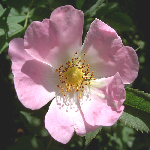

{'daisy_prob': 0.5996599197387695, 'dandelion_prob': 0.022527068853378296, 'flower': 'daisy', 'rose_prob': 0.2810279428958893, 'sunflower_prob': 0.002170732943341136, 'tulip_prob': 0.09461430460214615}
It is a daisy

https://upload.wikimedia.org/wikipedia/commons/a/a8/Tulipa_cinnabarina_subsp_cinnabarina.png


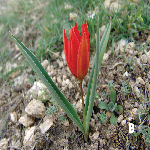

{'daisy_prob': 0.10178590565919876, 'dandelion_prob': 0.010768452659249306, 'flower': 'rose', 'rose_prob': 0.5585390329360962, 'sunflower_prob': 0.08482524752616882, 'tulip_prob': 0.24408146739006042}
It is a rose

https://upload.wikimedia.org/wikipedia/commons/8/85/Tulipa_praestans1.jpg


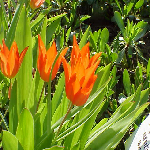

{'daisy_prob': 0.06188111752271652, 'dandelion_prob': 0.034026701003313065, 'flower': 'tulip', 'rose_prob': 0.037763215601444244, 'sunflower_prob': 0.19327868521213531, 'tulip_prob': 0.6730502843856812}
It is a tulip

https://upload.wikimedia.org/wikipedia/commons/e/ea/Tulipa_suaveolens_floriade_to_Canberra.jpg


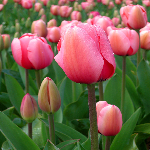

{'daisy_prob': 0.0033157351426780224, 'dandelion_prob': 0.0005222299369052052, 'flower': 'tulip', 'rose_prob': 0.21330875158309937, 'sunflower_prob': 0.0016595134511590004, 'tulip_prob': 0.7811937928199768}
It is a tulip

https://upload.wikimedia.org/wikipedia/commons/e/eb/Wild_Rosa_gallica_Romania.jpg


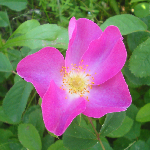

{'daisy_prob': 0.002528603421524167, 'dandelion_prob': 0.0001733688113745302, 'flower': 'rose', 'rose_prob': 0.8726898431777954, 'sunflower_prob': 1.2665306030612555e-06, 'tulip_prob': 0.12460688501596451}
It is a rose

https://upload.wikimedia.org/wikipedia/commons/0/0c/Rosa_Ave_Maria_1.jpg


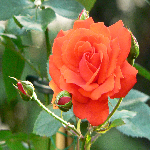

{'daisy_prob': 0.0026159710250794888, 'dandelion_prob': 8.896798681234941e-05, 'flower': 'rose', 'rose_prob': 0.666254997253418, 'sunflower_prob': 0.0027651749551296234, 'tulip_prob': 0.3282748758792877}
It is a rose

https://upload.wikimedia.org/wikipedia/commons/f/f7/2010_sonnenblume_%28Helianthus_annuus%29.JPG


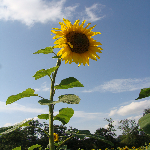

{'daisy_prob': 0.4557310938835144, 'dandelion_prob': 0.015460099093616009, 'flower': 'sunflower', 'rose_prob': 0.029218563809990883, 'sunflower_prob': 0.48284438252449036, 'tulip_prob': 0.01674596033990383}
It is a sunflower

https://upload.wikimedia.org/wikipedia/commons/e/e9/Sonsbeck_-_agri_06_ies.jpg


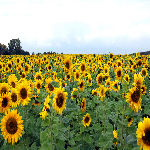

{'daisy_prob': 0.004504078533500433, 'dandelion_prob': 0.003341305535286665, 'flower': 'sunflower', 'rose_prob': 0.0005932832136750221, 'sunflower_prob': 0.9709368348121643, 'tulip_prob': 0.020624389871954918}
It is a sunflower

https://upload.wikimedia.org/wikipedia/commons/d/d6/Taraxacum_officinale_focused.jpg


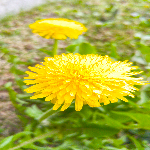

{'daisy_prob': 0.11769283562898636, 'dandelion_prob': 0.5363510251045227, 'flower': 'dandelion', 'rose_prob': 0.01699066162109375, 'sunflower_prob': 0.25923699140548706, 'tulip_prob': 0.06972851604223251}
It is a dandelion

https://upload.wikimedia.org/wikipedia/commons/8/85/01_pusteblume.jpg


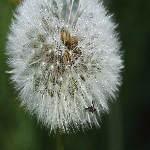

{'daisy_prob': 0.44862642884254456, 'dandelion_prob': 0.4319515526294708, 'flower': 'daisy', 'rose_prob': 0.07987377792596817, 'sunflower_prob': 0.010321824811398983, 'tulip_prob': 0.02922639064490795}
It is a daisy

https://upload.wikimedia.org/wikipedia/commons/5/5a/Bellis_perennis-fully_bloomed_flower.jpg


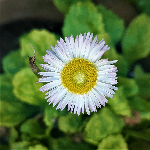

{'daisy_prob': 0.9613969922065735, 'dandelion_prob': 0.03049144521355629, 'flower': 'daisy', 'rose_prob': 0.005021701566874981, 'sunflower_prob': 0.00047968982835300267, 'tulip_prob': 0.0026101258117705584}
It is a daisy



In [18]:
for image_url in image_urls:
    print(image_url)
    img = download_image(image_url)
    img = resize_image(img, target_size)
    display(img)
    flower_pic_url = {'url': image_url}
    resp = requests.post(url, json=flower_pic_url).json()
    print(resp)
    print(f"It is a {resp['flower']}")
    print()